## **Food Image Classification using ResNet101 and ONNX Export**

This notebook trains a deep learning model (ResNet101) on the Food11 dataset for multi-class food image classification. It includes data preprocessing, data augmentation, model fine-tuning, loss tracking, and exports the trained model to ONNX format for efficient deployment on a serverless cloud platform (e.g., AWS Lambda with Docker).


In [ ]:
# Library imports
import os
import numpy as np
import tqdm
import glob
import zipfile
import shutil
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.onnx

In [ ]:
# Import the drive module from Google Colab to access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Define paths
zip_paths = [
    "/content/drive/My Drive/Food11_dataset/training.zip",  # Replace with your actual paths
    "/content/drive/My Drive/Food11_dataset/evaluation.zip",
    "/content/drive/My Drive/Food11_dataset/validation.zip"
]
extract_paths = [
    "/content/drive/My Drive/Food11_dataset/extracted_training",  # Path to extract training data
    "/content/drive/My Drive/Food11_dataset/extracted_evaluation",  # Path to extract evaluation data
    "/content/drive/My Drive/Food11_dataset/extracted_testing"  # Path to extract testing data
]

# Loop through each ZIP file and extract
for zip_path, extract_path in zip(zip_paths, extract_paths):
    # Remove existing directory (if any) to avoid conflicts
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)

    os.makedirs(extract_path, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Unzipping completed for {zip_path} into {extract_path}!")

Unzipping completed for /content/drive/My Drive/Food11_dataset/training.zip into /content/drive/My Drive/Food11_dataset/extracted_training!
Unzipping completed for /content/drive/My Drive/Food11_dataset/evaluation.zip into /content/drive/My Drive/Food11_dataset/extracted_evaluation!
Unzipping completed for /content/drive/My Drive/Food11_dataset/validation.zip into /content/drive/My Drive/Food11_dataset/extracted_testing!


### Image Preprocessing and Augmentation

To ensure the model receives properly formatted input, we apply a standard set of transformations:

- Resize: All images are resized to the target input size expected by ResNet (224×224).

- Normalization: We use dataset-specific mean and standard deviation to normalize pixel values.

- For training data, we add augmentations like rotation, horizontal flip, color jitter, and random erasing to improve generalization.

In [ ]:
# Define batch size for DataLoader (number of samples processed before model update)
batch_size = 32

# Target image dimensions for model input (height and width in pixels)
image_size = 224

# Normalization mean values [R, G, B] for ImageNet-like preprocessing
# These values are typically precomputed for the dataset
mean = [0.554, 0.450, 0.343]

# Normalization standard deviations [R, G, B] for scaling
std = [0.231, 0.241, 0.241]

In [ ]:
# Basic preprocessing transform for evaluation/validation data
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),    # Resize image to target size (e.g., 224x224)
    transforms.ToTensor(),                          # Convert image to PyTorch tensor and normalize pixel values to [0, 1]
    transforms.Normalize(mean=mean, std=std)        # Normalize using dataset-specific mean and std
])

# Augmentation transform for training data to improve generalization
aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),         # Resize to standard input size
    transforms.RandomRotation(20),                       # Randomly rotate images up to ±20 degrees
    transforms.RandomHorizontalFlip(),                   # Randomly flip images horizontally
    transforms.ColorJitter(0.1, 0.1, 0.1),                # Slight changes in brightness, contrast, and saturation
    transforms.ToTensor(),                               # Convert to tensor
    transforms.Normalize(mean, std),                     # Normalize using the same mean and std
    transforms.RandomErasing()                           # Randomly erase patches (regularization technique)
])

### Model Initialization

We use ResNet101, a deep convolutional neural network that has been pre-trained on ImageNet. Using a pre-trained model helps the training converge faster and improves performance on smaller datasets by leveraging learned features from a large corpus.

In [ ]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 171MB/s]


In [ ]:
in_features = int(model.fc.in_features)         # Get number of input features to the final fully connected layer
model.fc = nn.Linear(in_features, 11, device)   # Replace final layer to output 11 classes (for Food-11 dataset)

In [ ]:
model = model.to(device)

### Loss Function, Optimizer & Learning Rate Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
# Use cross-entropy loss for multi-class classification

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Stochastic Gradient Descent with learning rate = 0.001 and momentum = 0.9

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# Reduce learning rate by a factor of 0.1 every 5 epochs

### Dataset Loading and DataLoader Setup

In [ ]:
train_dataset = datasets.ImageFolder(extract_paths[0], transform=aug_transform)
# Load training dataset with data augmentation transforms

evaluation_dataset = datasets.ImageFolder(extract_paths[1], transform=transform)
# Load validation dataset with basic preprocessing only

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# Create DataLoader for training — shuffle data to ensure randomness

evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# Create DataLoader for evaluation — no shuffle needed for validation


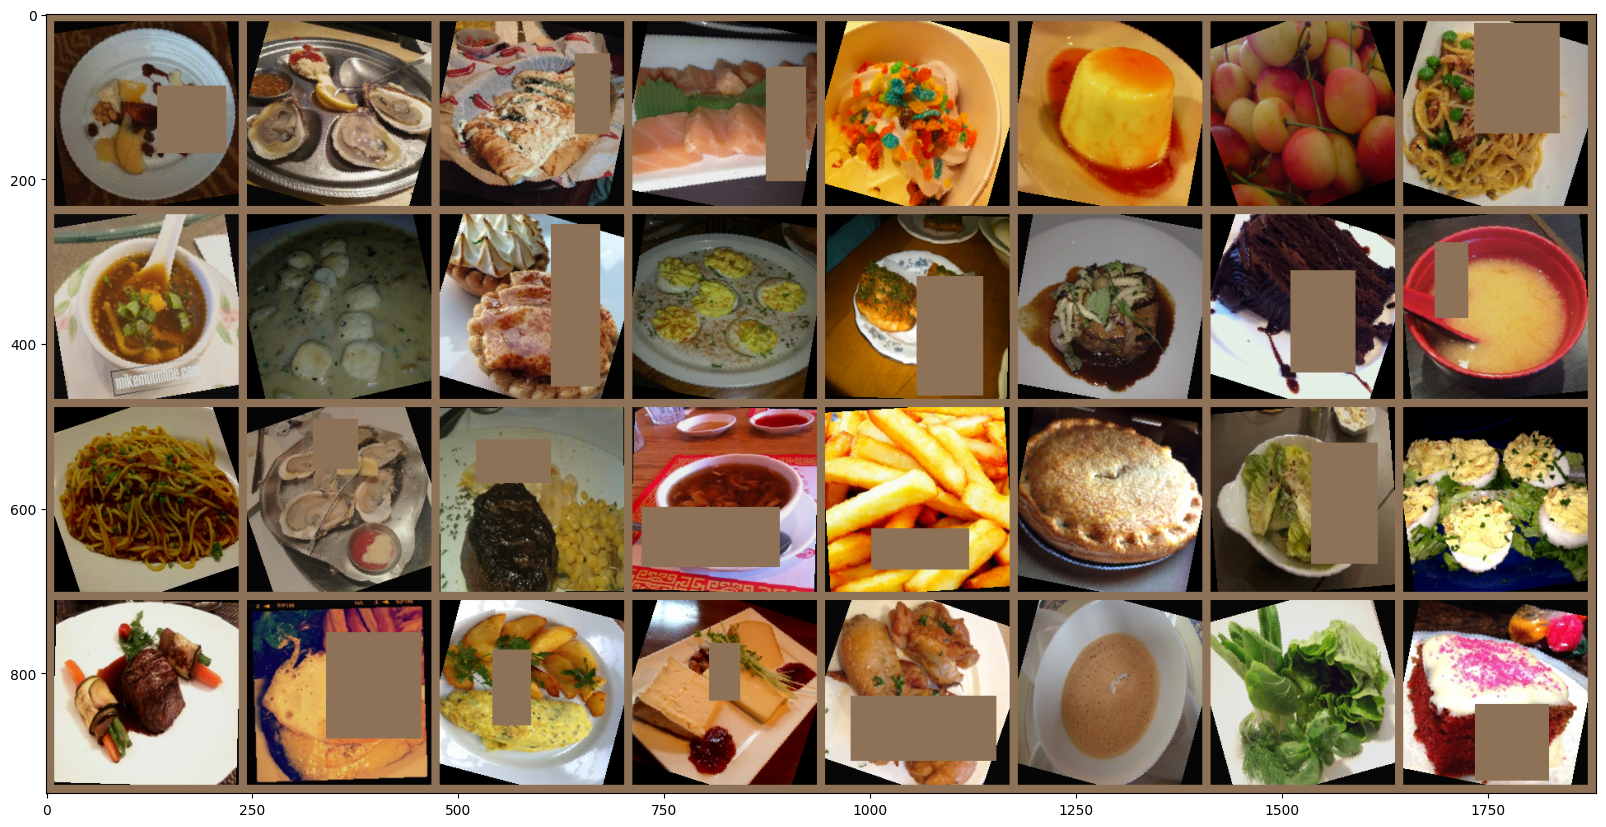

In [ ]:
images, targets = next(iter(train_dataloader))
# Get a single batch of training images and labels

grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)
# Arrange images in a grid for visualization

def imshow(images, mean, std):
    np_image = np.array(images).transpose((1, 2, 0))         # Convert from CHW to HWC for displaying
    unnorm_image = np_image * std + mean                     # Unnormalize the image
    plt.figure(figsize=(20, 20))                             # Set figure size
    plt.imshow(unnorm_image)                                 # Display image

imshow(grid_images, mean, std)
# Display a batch of training images

### Training Loop and Model Saving

In [ ]:
num_epochs = 15
losses = []

# Loop through each epoch
for epoch in range(num_epochs):

    # Loop through each batch in the training DataLoader
    for i, (inputs, targets) in enumerate(train_dataloader):

        # Move inputs and labels to the GPU/CPU device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass to get predictions
        outputs = model(inputs)

        # Calculate loss between predictions and actual targets
        loss = criterion(outputs, targets)
        losses.append(loss.item())  # Save loss for plotting

        # Zero out gradients from the previous step
        optimizer.zero_grad()

        # Backpropagate the error
        loss.backward()

        # Update model weights
        optimizer.step()

        # Print loss every 50 steps to track progress
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.item()))

# Save the trained model to Google Drive for later use
model_path = '/content/drive/My Drive/Food11_dataset/model.pth'
torch.save(model, model_path)

Epoch [ 1/15], Step [ 50/308], Loss: 1.7744
Epoch [ 1/15], Step [100/308], Loss: 0.8048
Epoch [ 1/15], Step [150/308], Loss: 0.9102
Epoch [ 1/15], Step [200/308], Loss: 0.6376
Epoch [ 1/15], Step [250/308], Loss: 0.5503
Epoch [ 1/15], Step [300/308], Loss: 0.3851
Epoch [ 2/15], Step [ 50/308], Loss: 0.2227
Epoch [ 2/15], Step [100/308], Loss: 0.6117
Epoch [ 2/15], Step [150/308], Loss: 0.6064
Epoch [ 2/15], Step [200/308], Loss: 0.2623
Epoch [ 2/15], Step [250/308], Loss: 0.2858
Epoch [ 2/15], Step [300/308], Loss: 0.3373
Epoch [ 3/15], Step [ 50/308], Loss: 0.3713
Epoch [ 3/15], Step [100/308], Loss: 0.8161
Epoch [ 3/15], Step [150/308], Loss: 0.3451
Epoch [ 3/15], Step [200/308], Loss: 0.4691
Epoch [ 3/15], Step [250/308], Loss: 0.1466
Epoch [ 3/15], Step [300/308], Loss: 0.3957
Epoch [ 4/15], Step [ 50/308], Loss: 0.2258
Epoch [ 4/15], Step [100/308], Loss: 0.1664
Epoch [ 4/15], Step [150/308], Loss: 0.4288
Epoch [ 4/15], Step [200/308], Loss: 0.2457
Epoch [ 4/15], Step [250/308], L

In [ ]:
!pip install onnx --quiet

# Define path to save the ONNX model
onnx_model_path = '/content/model.onnx'

# Create a dummy input tensor with the same size as the input to your model
# ResNet101 expects an input of size [batch_size, 3, 224, 224]
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Set the model to evaluation mode (important before exporting)
model.eval()

# Export the model to ONNX format
torch.onnx.export(model,
                  dummy_input,
                  onnx_model_path,
                  input_names=['input'],
                  output_names=['output'],
                  opset_version=11,  # Ensure compatibility with most platforms
                  do_constant_folding=True,  # Optimization: fold constants
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # Dynamic batch size support

print(f"Model has been saved as {onnx_model_path}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 64.8 MB/s eta 0:00:00
Model has been saved as /content/model.onnx


In [ ]:
torch.save(model, 'model_adv_project.pth')

### Loss Curve Visualization

This plot helps visualize how the training loss decreases over time, indicating whether the model is learning effectively.

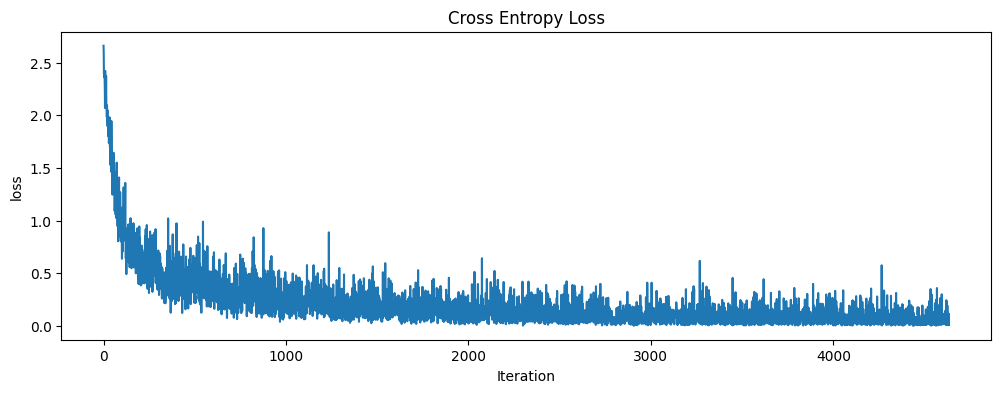

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Model Evaluation Function

In [ ]:
# Define a function to evaluate model accuracy on a given dataset
def evaluate_model(model, dataloader, device):

    # Set model to evaluation mode (important for layers like BatchNorm, Dropout)
    model.eval()

    # Initialize counter to track correct predictions
    corrects = 0

    # Disable gradient calculations to save memory and computation
    with torch.no_grad():

        # Iterate through the entire dataset in batches
        for inputs, targets in dataloader:

            # Move inputs and labels to the correct device (CPU/GPU)
            inputs, targets = inputs.to(device), targets.to(device)

            # Get model predictions
            outputs = model(inputs)

            # Find the predicted class (the one with highest score)
            _, preds = torch.max(outputs, 1)

            # Count correct predictions
            corrects += (preds == targets.data).sum()

    # Calculate and print final accuracy
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [ ]:
#training accuracy
evaluate_model(model, train_dataloader, device)

accuracy: 98.85


In [ ]:
#validation accuracy
evaluate_model(model, evaluation_dataloader, device)

accuracy: 94.65


### Inference with Exported ONNX Model

In [ ]:
# Install required packages for ONNX model inference
!pip install onnxruntime --quiet
!pip install onnx --quiet

# Import necessary libraries
import onnx
import onnxruntime as ort
import numpy as np
from PIL import Image
from torchvision import transforms

# Load the exported ONNX model from disk
onnx_model_path = '/content/model.onnx'
ort_session = ort.InferenceSession(onnx_model_path)

# Define preprocessing parameters (same used during training)
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
image_size = 224

# Create a preprocessing pipeline: resize → tensor → normalize
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the test image using PIL
image_path = '/content/rc.jpeg'  # Replace with actual test image path
img = Image.open(image_path)

# Apply preprocessing and add batch dimension
img = transform(img).unsqueeze(0)

# Convert PyTorch tensor to NumPy array for ONNX Runtime
img = img.numpy()

# Prepare input dictionary and run inference
inputs = {ort_session.get_inputs()[0].name: img}
outputs = ort_session.run(None, inputs)

# Extract predicted class index using argmax
predicted_class = np.argmax(outputs[0], axis=1)

# Print the prediction result
print(f'Predicted Class: {predicted_class[0]}')

Predicted Class: 7
